In the previous notebook, we focused on exploring mitosis vs. normal images and how they differed in various attributes, and coding different classifiers to seperate mitosis and normal images.

Although we had relatively good accuracies (> 90%) in identifying mitosis vs normal images, when we actually applied the classifier to the image, it detected a lot of "random" nuclei as mitosis, without any real pattern. We try to fix that here by first detecting all nuclei, then making a set including mitotic and non-mitotic nuclei.



In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

from urllib import urlretrieve
import cPickle as pickle
import os
import glob
import sys
import gzip

import numpy as np
import theano

from keras.utils import np_utils
import sklearn
import sknn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from PIL import Image
import codecs

import csv
import xlrd

In [14]:
# Constants
SIZE = 2084
PATCH_SIZE = 40
NUM = 20
VAL_NUM = 11
PATCH_NUM = 20000*NUM
VAL_PATCH_NUM = 144
split = 0.7
TRAIN = "train/A0";
TEST = "test/A0";
retrain = True

This is Dayong's code for nuclei segmentation.

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  9 11:32:05 2016

@author: dayong
"""
import numpy as np
from scipy import ndimage as nd
import skimage as ski
import skimage.io as skio
from skimage.exposure import rescale_intensity
from skimage import morphology
import scipy.ndimage.morphology as smorphology
from scipy.ndimage import gaussian_filter
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
#from skimage.filters import gaussian_filter

def nuclei_detect_pipeline(img, MinPixel = 200, MaxPixel=2500):
    sn = stain_normliazation('nuclei_v1_matlab/StainNormalization/ref.png')
    nimg = sn.stain(img)
    return nimg, nuclei_detection_cancer(nimg, MinPixel, MaxPixel)

def nuclei_detection_cancer(img, MinPixel, MaxPixel, debug = False):
    img_f = ski.img_as_float(img)
    adjustRed = rescale_intensity(img_f[:,:,0])
    adjustRed[adjustRed < 0.5] = 1
    roiGamma = rescale_intensity(adjustRed, in_range=(0, 0.8));
    roiMaskThresh = roiGamma < (250 / 255.0) ;

    roiMaskFill = morphology.remove_small_objects(~roiMaskThresh, MinPixel);
    roiMaskNoiseRem = morphology.remove_small_objects(~roiMaskFill,150);
    roiMaskDilat = morphology.opening(roiMaskNoiseRem, morphology.disk(10));
    cancer_bw = smorphology.binary_fill_holes(roiMaskDilat)

    img_f = ski.img_as_float(img)
    adjustRed = rescale_intensity(img_f[:,:,0])
    roiGamma = rescale_intensity(adjustRed, in_range=(0, 0.5));
    roiMaskThresh = roiGamma < (250 / 255.0) ;

    roiMaskFill = morphology.remove_small_objects(~roiMaskThresh, MinPixel);
    roiMaskNoiseRem = morphology.remove_small_objects(~roiMaskFill,150);
    roiMaskDilat = morphology.opening(roiMaskNoiseRem, morphology.disk(5));
    roiMask = smorphology.binary_fill_holes(roiMaskDilat)

    hsv = ski.color.rgb2hsv(img);
    hsv[:,:,2] = 0.8;
    img2 = ski.color.hsv2rgb(hsv)
    diffRGB = img2-img_f
    adjRGB = np.zeros(diffRGB.shape)
    adjRGB[:,:,0] = rescale_intensity(diffRGB[:,:,0],in_range=(0, 0.4))
    adjRGB[:,:,1] = rescale_intensity(diffRGB[:,:,1],in_range=(0, 0.4))
    adjRGB[:,:,2] = rescale_intensity(diffRGB[:,:,2],in_range=(0, 0.4))

    gauss = gaussian_filter(adjRGB[:,:,2], sigma=3, truncate=5.0);

    bw1 = gauss>(100/255.0);
    bw1 = bw1 * roiMask;
    bw1_bwareaopen = morphology.remove_small_objects(bw1, MinPixel)
    bw2 = smorphology.binary_fill_holes(bw1_bwareaopen);

    bwDist = nd.distance_transform_edt(bw2);
    filtDist = gaussian_filter(bwDist,sigma=5, truncate=5.0);

    bw3 = np.logical_or(bw2, cancer_bw)

    L = label(bw3)
    L = clear_border(L)
    R = regionprops(L)
    coutn = 0
    for idx, R_i in enumerate(R):
        #print(idx, R_i['area'], MinPixel, MaxPixel)
        if R_i['area'] > MaxPixel or R_i['area'] < MinPixel:
            L[L==R_i['label']] = 0
        else:
            r, l = R_i['centroid']
            #pass
    BW = L > 0

    if debug:
        plt.figure(1)
        skio.imshow(L)
        plt.show()
    return BW

def nuclei_detection(img, MinPixel, MaxPixel):
    img_f = ski.img_as_float(img)
    adjustRed = rescale_intensity(img_f[:,:,0])
    roiGamma = rescale_intensity(adjustRed, in_range=(0, 0.5));
    roiMaskThresh = roiGamma < (250 / 255.0) ;

    roiMaskFill = morphology.remove_small_objects(~roiMaskThresh, MinPixel);
    roiMaskNoiseRem = morphology.remove_small_objects(~roiMaskFill,150);
    roiMaskDilat = morphology.dilation(roiMaskNoiseRem, morphology.disk(3));
    roiMask = smorphology.binary_fill_holes(roiMaskDilat)

    hsv = ski.color.rgb2hsv(img);
    hsv[:,:,2] = 0.8;
    img2 = ski.color.hsv2rgb(hsv)
    diffRGB = img2-img_f
    adjRGB = np.zeros(diffRGB.shape)
    adjRGB[:,:,0] = rescale_intensity(diffRGB[:,:,0],in_range=(0, 0.4))
    adjRGB[:,:,1] = rescale_intensity(diffRGB[:,:,1],in_range=(0, 0.4))
    adjRGB[:,:,2] = rescale_intensity(diffRGB[:,:,2],in_range=(0, 0.4))

    gauss = gaussian_filter(adjRGB[:,:,2], sigma=3, truncate=5.0);

    bw1 = gauss>(100/255.0);
    bw1 = bw1 * roiMask;
    bw1_bwareaopen = morphology.remove_small_objects(bw1, MinPixel)
    bw2 = smorphology.binary_fill_holes(bw1_bwareaopen);

    bwDist = nd.distance_transform_edt(bw2);
    filtDist = gaussian_filter(bwDist,sigma=5, truncate=5.0);

    L = label(bw2)
    R = regionprops(L)
    coutn = 0
    for idx, R_i in enumerate(R):
        if R_i.area < MaxPixel and R_i.area > MinPixel:
            r, l = R_i.centroid
            #print(idx, filtDist[r,l])
        else:
            L[L==(idx+1)] = 0
    BW = L > 0
    return BW

class stain_normliazation:
    def __get_mv_sv(self, img):
        mv,sv = [],[]
        for i in range(3):
            mv.append(np.mean(img[:,:,i]))
            sv.append(np.std(img[:,:,i]))
        return mv, sv
    def __init__(self, ref_name):
        self.img_ref = skio.imread(ref_name)
        self.img_ref_lab = ski.color.rgb2lab(self.img_ref)
        self.mv, self.sv = self.__get_mv_sv(self.img_ref_lab)
        #print self.mv, self.sv
    def stain(self, img):
        img_lab = ski.color.rgb2lab(img)
        mv, sv = self.__get_mv_sv(img_lab)
        #print mv, sv
        for i in range(3):
            img_lab[:,:,i] = ((img_lab[:,:,i] - mv[i]) * (self.sv[i] / sv[i])) + self.mv[i]
        img2 = ski.color.lab2rgb(img_lab)
        if 0:
            plt.subplot(131); skio.imshow(self.img_ref)
            plt.subplot(132); skio.imshow(img)
            plt.subplot(133); skio.imshow(img2)
        img2_ui = ski.img_as_ubyte(img2)
        return img2_ui


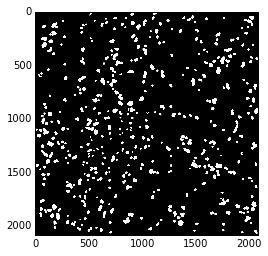

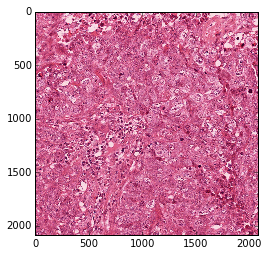

In [58]:
imgFile = TRAIN + "1_01.bmp"
img = plt.imread(imgFile);
nimg, nuclei_map = nuclei_detect_pipeline(img)
plt.imshow(nuclei_map, cmap="gray")
plt.show()

plt.imshow(nimg)
plt.show()

Now, we go through all images inside the "train" directory, detect the nuclei, and make a dataset!

In [10]:
# First, we need a way to flood the nuclei regions

minx, miny, maxx, maxy = (SIZE, SIZE, 0, 0)
def floodfill(x, y):
    global minx, miny, maxx, maxy, flood_mask
    if not flood_mask[x, y]:
        return False
    minx = min(x, minx)
    miny = min(y, miny)
    maxx = max(x, maxx)
    maxy = max(y, maxy)
    flood_mask[x, y] = False;
    floodfill(x + 1, y)
    floodfill(x, y + 1)
    floodfill(x - 1, y)
    floodfill(x, y - 1)
    return True


In [7]:
# Constants
SIZE = 2084
PATCH_SIZE = 50
NUM = 20
VAL_NUM = 11
PATCH_NUM = 2000*NUM
VAL_PATCH_NUM = 144
split = 0.7
TRAIN = "train/A0";
TEST = "test/A0";
retrain = True

In [277]:
trainImg = np.zeros((PATCH_NUM, PATCH_SIZE, PATCH_SIZE, 3))
trainVal = np.zeros((PATCH_NUM))
coords = []


sys.setrecursionlimit(10000)

cnt = 0
for filename in glob.iglob("train/*.bmp"):
    print filename
    annotFile = filename[:-3] + "csv"
    print annotFile
    img = plt.imread(filename);
    
    imgMask = np.zeros((SIZE, SIZE));
    csvReader = csv.reader(codecs.open(annotFile, 'rU', 'utf-8'))
    
    for row in csvReader:
        for i in range(0, len(row)/2):
            xv, yv = (int(row[2*i]), int(row[2*i+1]))
            imgMask[yv, xv] = 1
    
    nimg, nuclei_map = nuclei_detect_pipeline(img)
    flood_mask = nuclei_map
    for i in range(PATCH_SIZE, SIZE - PATCH_SIZE):
        for j in range(PATCH_SIZE, SIZE - PATCH_SIZE):
            minx, miny, maxx, maxy = (SIZE, SIZE, 0, 0)
            if floodfill(i, j):
                sx = (minx + maxx)/2 - PATCH_SIZE/2
                sy = (miny + maxy)/2 - PATCH_SIZE/2
                for di in range(0, PATCH_SIZE):
                    for dj in range(0, PATCH_SIZE):
                        try:
                            trainImg[cnt, di, dj] = np.divide(nimg[sx + di, sy + dj], 255.0)
                        except:
                            print ("error")
                        if imgMask[sx + di, sy + dj] == 1:
                            trainVal[cnt] = trainVal[cnt] + 1
                if trainVal[cnt] > PATCH_SIZE*PATCH_SIZE/10:
                    trainVal[cnt] = 1
                else:
                    trainVal[cnt] = 0
                cnt = cnt + 1
                coords.append((minx, miny, maxx, maxy))
                
    #break #to run with only one image for testing purposes
PATCH_NUM_upd = cnt
trainImg = trainImg[0:PATCH_NUM_upd]
trainVal = trainVal[0:PATCH_NUM_upd]

train/A00_01.bmp
train/A00_01.csv
train/A00_02.bmp
train/A00_02.csv
train/A00_03.bmp
train/A00_03.csv
train/A00_04.bmp
train/A00_04.csv
train/A00_05.bmp
train/A00_05.csv
train/A00_06.bmp
train/A00_06.csv
train/A00_07.bmp
train/A00_07.csv
train/A00_09.bmp
train/A00_09.csv
train/A01_00.bmp
train/A01_00.csv
train/A01_01.bmp
train/A01_01.csv
train/A01_02.bmp
train/A01_02.csv
train/A01_03.bmp
train/A01_03.csv
train/A01_05.bmp
train/A01_05.csv
train/A01_07.bmp
train/A01_07.csv
train/A01_08.bmp
train/A01_08.csv
train/A02_02.bmp
train/A02_02.csv
train/A02_04.bmp
train/A02_04.csv
train/A02_05.bmp
train/A02_05.csv
train/A02_06.bmp
train/A02_06.csv
train/A02_08.bmp
train/A02_08.csv
train/A02_09.bmp
train/A02_09.csv
train/A03_02.bmp
train/A03_02.csv
train/A03_03.bmp
train/A03_03.csv
train/A03_05.bmp
train/A03_05.csv
train/A03_06.bmp
train/A03_06.csv
train/A03_07.bmp
train/A03_07.csv
train/A03_08.bmp
train/A03_08.csv
train/A03_09.bmp
train/A03_09.csv
train/A04_00.bmp
train/A04_00.csv
train/A04_01.b

In [75]:
## Save data

np.save("trainImg_stage2.npy", trainImg)
np.save("trainVal_stage2.npy", trainVal)

print trainImg.shape
print sum(trainVal)

(17350, 54, 54, 3)
159.0


In [5]:
# Alternatively, load data from save
trainImg = np.load("trainImg_stage2.npy")
trainVal = np.load("trainVal_stage2.npy")

Now, let's generate a random mitosis and normal image, and a full set of images evenly balanced between mitosis and non-mitosis.

In [6]:
#random mitosis image

from sklearn.utils import shuffle

mitosisSet = []
for i in range(0, len(trainVal)):
    if trainVal[i] == 1:
        mitosisSet.append(i)

normalSet = []
for i in shuffle(range(0, len(trainVal))):
    if trainVal[i] == 0 and len(normalSet) < 20*len(mitosisSet):
        normalSet.append(i)

fullSet = normalSet
for i in range(0, 20):
    fullSet = fullSet + mitosisSet
fullSet = shuffle(fullSet)
print "Length of full set:",len(fullSet)
print fullSet

Length of full set: 6360
[13862, 17316, 14072, 14822, 13729, 4785, 12882, 5380, 12076, 12769, 16523, 3281, 11465, 16433, 16445, 7746, 15066, 12190, 905, 8314, 2010, 11946, 5637, 10391, 1376, 15558, 5420, 3505, 9976, 16964, 17260, 5999, 6359, 13729, 14175, 12774, 12906, 17197, 444, 5096, 10608, 3140, 11755, 14824, 3406, 8760, 16084, 3273, 8903, 12940, 11002, 12076, 6249, 10433, 5636, 13301, 1535, 9245, 14814, 13976, 5551, 6223, 11075, 5637, 13136, 16680, 3528, 6132, 4919, 7279, 16256, 16364, 43, 4721, 14647, 5636, 4817, 9775, 10283, 10788, 13489, 555, 11189, 14087, 7032, 5313, 16673, 5420, 11434, 5500, 13301, 4036, 212, 5593, 1427, 4439, 43, 11148, 7974, 11002, 15706, 15492, 12292, 5296, 5209, 10984, 16859, 8683, 11728, 15819, 5985, 8457, 10186, 7985, 10062, 13541, 11781, 16571, 7102, 7703, 14103, 11294, 17316, 12283, 4478, 904, 16946, 15298, 8041, 369, 7319, 14380, 12882, 5420, 5969, 6486, 10433, 10533, 15706, 9016, 6223, 13305, 16949, 555, 1575, 11034, 12863, 2299, 2787, 5420, 4070, 9

Mitosis 6384


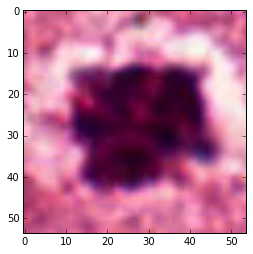

Normal 644


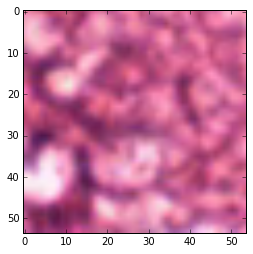

In [7]:
import random

mitosis = random.choice(mitosisSet)
print "Mitosis",mitosis

%matplotlib inline

#(minx1, miny1, maxx1, maxy1) = coords[mitosis]
#sx = (minx1 + maxx1)/2 - PATCH_SIZE/2
#sy = (miny1 + maxy1)/2 - PATCH_SIZE/2

plt.imshow(trainImg[mitosis])
plt.show();
#print coords[mitosis]
#plt.imshow(plt.imread("train/A00_01.jpg")[sx:sx + PATCH_SIZE, sy:sy + PATCH_SIZE])
#plt.show()




normal = random.choice(normalSet)
print "Normal",normal

%matplotlib inline
plt.imshow(trainImg[normal])
plt.show()

Now that we have a dataset of mitotic and challenging non-mitotic patches, let's train a classifier to distinguish between the two sets.

In [9]:
from sknn.platform import gpu32
from sknn.mlp import Classifier, Layer, Convolution
from sklearn import cross_validation

nn_old = pickle.load( open( "nn_equal_patch.pkl", "rb" ) )

trainImg = trainImg.astype(np.float32)
trainInt = trainVal.astype(np.uint8)

sys.setrecursionlimit(10000)

print trainImg.shape

print "Building Classfier:"
nn = Classifier(
    layers=[
        Convolution("Rectifier", channels=128, kernel_shape=(4,4), pool_shape = (2, 2)),
        Convolution("Rectifier", channels=192, kernel_shape=(4,4), pool_shape = (2, 2), dropout = 0.3),
        Convolution("Rectifier", channels=256, kernel_shape=(4,4), pool_shape = (2, 2), dropout = 0.3),
        Layer("Rectifier", units=312, dropout = 0.4),
        Layer("Softmax")],
    #weights=nn_old.weights,
    learning_rate=0.001, verbose = True,
    n_iter=30)

print "Training Classifier: 70/30 split"
X_train, X_test, y_train, y_test = cross_validation.train_test_split(trainImg[fullSet], trainInt[fullSet])
nn.fit(X_train, y_train)
score = nn.score(X_test, y_test)
print score

(17350, 54, 54, 3)
Building Classfier:
Training Classifier: 70/30 split
.....

KeyboardInterrupt: 

In [274]:
from sklearn.metrics import roc_auc_score

#Further analysis
probs = nn.predict_proba(X_test)
probs_filtered = []
for prob in probs:
    probs_filtered.append(prob[1])
print y_test
auc = roc_auc_score(y_test, probs_filtered, average = 'macro')
print "AUC",auc

pickle.dump(nn, open( "nn_stage2.pkl", "wb" ))

[(80, 2)]
[0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0
 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0
 0 1 0 1 1 1]
AUC 0.915413533835


In [8]:
# alternatively, load classifier as nn
nn = pickle.load( open( "nn_stage2.pkl", "rb" ) )

print "Loaded Net"
y_pred = nn.predict(trainImg[fullSet])
print y_pred
cm = confusion_matrix(trainInt[fullSet], y_pred)

print('Confusion matrix, without normalization')
print(cm)
plt.figure()

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")
/Users/nikcheerla/src/lasagne/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


Loaded Net
[(6360, 2)]
[[0]
 [1]
 [1]
 ..., 
 [1]
 [0]
 [1]]


NameError: name 'trainInt' is not defined

This is a pretty good testing accuracy, especially considering how difficult it is to accurately discriminate. Let's make a routine to figure out what this classifier thinks is mitosis.

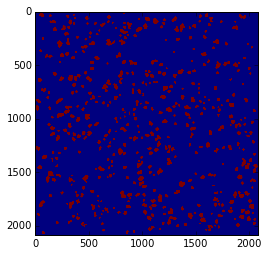

[(233, 51, 273, 91), (454, 808, 494, 848), (561, 1983, 601, 2023), (614, 1799, 654, 1839), (638, 1114, 678, 1154), (662, 1015, 702, 1055), (766, 983, 806, 1023), (775, 578, 815, 618), (835, 618, 875, 658), (873, 1686, 913, 1726), (930, 858, 970, 898), (924, 817, 964, 857), (948, 1687, 988, 1727), (978, 776, 1018, 816), (1088, 259, 1128, 299), (1204, 679, 1244, 719), (1243, 1521, 1283, 1561), (1364, 140, 1404, 180), (1418, 180, 1458, 220), (1511, 322, 1551, 362), (1588, 1347, 1628, 1387), (1604, 1641, 1644, 1681), (1798, 574, 1838, 614), (1816, 1352, 1856, 1392), (1911, 1970, 1951, 2010), (1967, 435, 2007, 475), (1954, 1516, 1994, 1556)]


In [18]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

sys.setrecursionlimit(10000)


nn = pickle.load( open( "nn_pixel_based_2.pkl", "rb" ) )


flood_mask = np.zeros((SIZE, SIZE))
minx, miny, maxx, maxy = (SIZE, SIZE, 0, 0)

def findMitosis(img, thresh=0.5):
    global flood_mask, minx, miny, maxx, maxy
    
    nimg, nuclei_map = nuclei_detect_pipeline(img)
    flood_mask = nuclei_map
    
    plt.imshow(flood_mask)
    plt.show()
    patch = np.zeros((1, PATCH_SIZE, PATCH_SIZE, 3))
    patch = np.swapaxes(patch, 1, 3)
    coords = []
    probs = []
    for i in range(PATCH_SIZE, SIZE - PATCH_SIZE):
        for j in range(PATCH_SIZE, SIZE - PATCH_SIZE):
            minx, miny, maxx, maxy = (SIZE, SIZE, 0, 0)
            if floodfill(i, j):
                sx = (minx + maxx)/2 - PATCH_SIZE/2
                sy = (miny + maxy)/2 - PATCH_SIZE/2
                patch = np.swapaxes(patch, 1, 3)
                for di in range(0, PATCH_SIZE):
                    for dj in range(0, PATCH_SIZE):
                        patch[0, di, dj] = np.divide(img[sx + di, sy + dj], 255.0)
                patch = np.swapaxes(patch, 1, 3)
                with suppress_stdout():
                    prob = nn.predict_proba(patch)[0, 1]
                if prob > thresh:
                    coords.append((sx, sy, sx + PATCH_SIZE, sy + PATCH_SIZE))
                    probs.append(prob)
    return (coords, probs)

imgValFile = "train/A01_00.bmp"
imgValFileColored = "train/A01_00.jpg"
        
coords, probs = findMitosis(plt.imread(imgValFile), 0.75)
print coords

0.999987026399


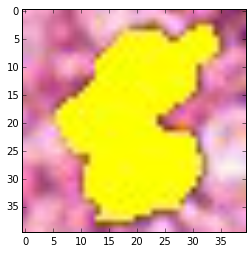

0.971332642456


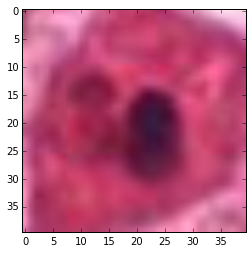

0.897728719477


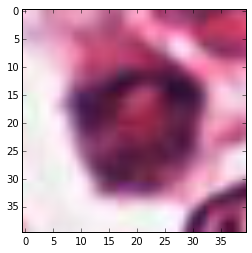

0.82698860332


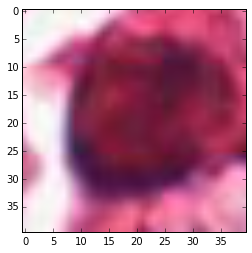

0.982763375014


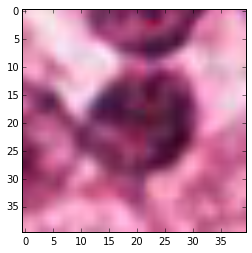

0.998118268133


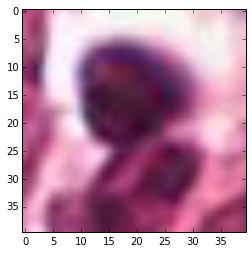

0.959656440871


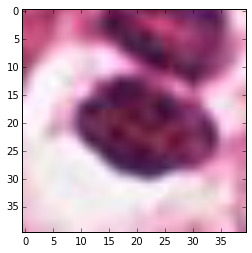

0.992103301475


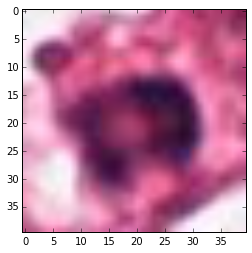

0.814947667488


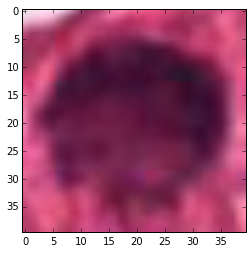

0.980232066932


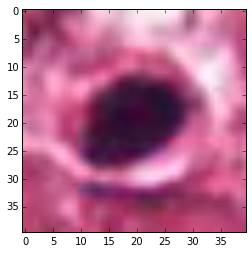

0.996378443491


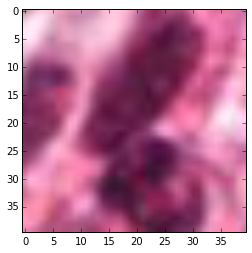

0.808625030894


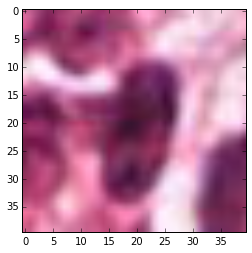

0.996113615771


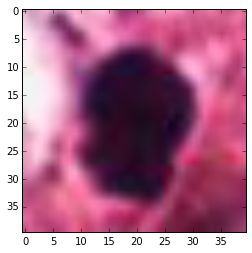

0.816816660059


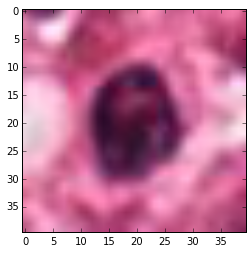

0.999970075718


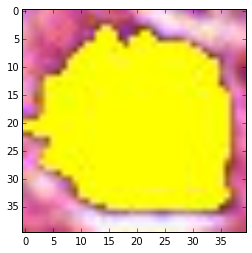

0.927900885657


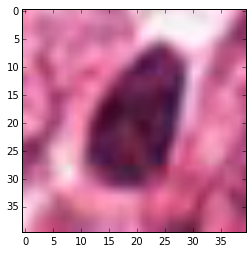

0.99999460438


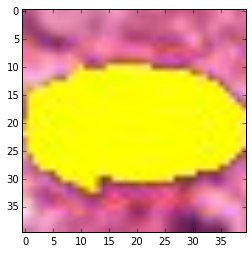

0.987733800189


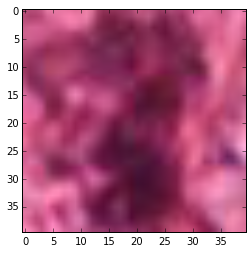

0.999652125923


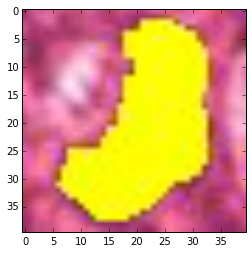

0.796810332929


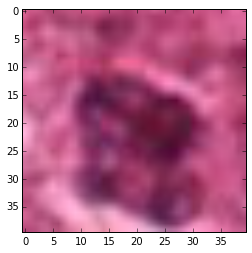

0.763913083082


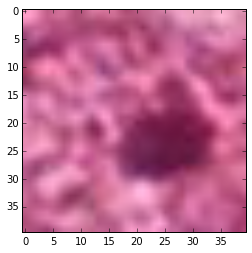

0.999692648488


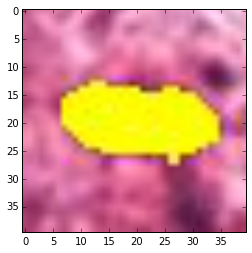

0.7992351792


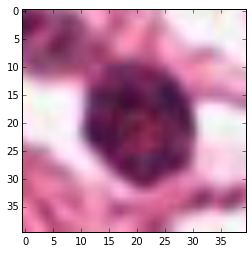

0.995071247624


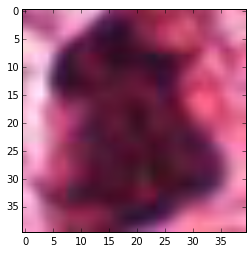

0.999537626083


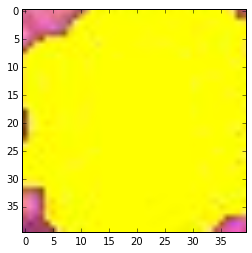

0.999994980867


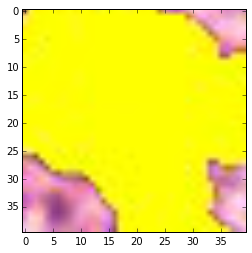

0.999391076758


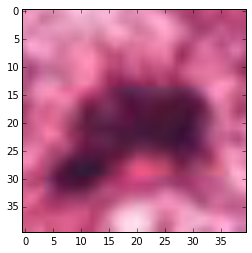

In [19]:
for ((sx, sy, rnn, rnn2), prob) in zip(coords, probs):
    print prob
    plt.imshow(plt.imread(imgValFileColored)[sx:sx + PATCH_SIZE, sy:sy + PATCH_SIZE])
    plt.show()


It seems to detect most, if not all of the mitosis images, but it does have some false positives. White areas (staining?) seem to affect the detection.

Now, we examine the AUC on a completely unseen test set by finding every cell in the test set and classifying.

In [308]:
testImg = np.zeros((PATCH_NUM, PATCH_SIZE, PATCH_SIZE, 3))
testVal = np.zeros((PATCH_NUM))


sys.setrecursionlimit(10000)
print "Recursing"
cnt = 0
for filename in glob.iglob("test/*.bmp"):
    print filename
    annotFile = filename[:-3] + "csv"
    print annotFile
    img = plt.imread(filename);
    
    imgMask = np.zeros((SIZE, SIZE));
    csvReader = csv.reader(codecs.open(annotFile, 'rU', 'utf-8'))
    
    for row in csvReader:
        for i in range(0, len(row)/2):
            xv, yv = (int(row[2*i]), int(row[2*i+1]))
            imgMask[yv, xv] = 1
    
    nimg, nuclei_map = nuclei_detect_pipeline(img)
    flood_mask = nuclei_map
    for i in range(PATCH_SIZE, SIZE - PATCH_SIZE):
        for j in range(PATCH_SIZE, SIZE - PATCH_SIZE):
            minx, miny, maxx, maxy = (SIZE, SIZE, 0, 0)
            if floodfill(i, j):
                sx = (minx + maxx)/2 - PATCH_SIZE/2
                sy = (miny + maxy)/2 - PATCH_SIZE/2
                for di in range(0, PATCH_SIZE):
                    for dj in range(0, PATCH_SIZE):
                        try:
                            testImg[cnt, di, dj] = np.divide(nimg[sx + di, sy + dj], 255.0)
                        except:
                            print ("ERROROROROROR")
                            print (sx, sy)
                            print (di, dj)
                        if imgMask[sx + di, sy + dj] == 1:
                            testVal[cnt] = testVal[cnt] + 1
                            #print "OMGOMGOMGOMG"
                if testVal[cnt] > PATCH_SIZE*PATCH_SIZE/10:
                    testVal[cnt] = 1
                else:
                    testVal[cnt] = 0
                cnt = cnt + 1
                coords.append((minx, miny, maxx, maxy))
    #break #to run with only one image for testing purposes
PATCH_NUM_upd = cnt
testImg = testImg[0:PATCH_NUM_upd]
testVal = testVal[0:PATCH_NUM_upd]

print testImg.shape

Recursing
test/A00_00.bmp
test/A00_00.csv
test/A00_08.bmp
test/A00_08.csv
test/A01_04.bmp
test/A01_04.csv
test/A01_06.bmp
test/A01_06.csv
test/A01_09.bmp
test/A01_09.csv
test/A02_00.bmp
test/A02_00.csv
test/A02_01.bmp
test/A02_01.csv
test/A02_03.bmp
test/A02_03.csv
test/A02_07.bmp
test/A02_07.csv
test/A03_00.bmp
test/A03_00.csv
test/A03_01.bmp
test/A03_01.csv
test/A03_04.bmp
test/A03_04.csv
test/A04_03.bmp
test/A04_03.csv
test/A04_07.bmp
test/A04_07.csv
test/A04_09.bmp
test/A04_09.csv
(7493, 54, 54, 3)


In [309]:
#Save data
print (sum(testVal))
np.save("testImg_stage2.npy", testImg)
np.save("testVal_stage2.npy", testVal)

58.0


In [20]:
# Alternatively, load from save

testImg = np.load("testImg_stage2.npy")
testVal = np.load("testVal_stage2.npy")
print testImg.shape
print sum(testVal)

(7493, 54, 54, 3)
58.0


In [27]:
# Calculate AUC
from sklearn.metrics import roc_auc_score

#testImg = np.swapaxes(testImg, 1, 3)
print testImg.shape

probs = nn.predict_proba(testImg)
probs_filtered = []
for prob in probs:
    probs_filtered.append(prob[1])

auc = roc_auc_score(testVal, probs_filtered, average = 'macro')
print "AUC",auc

(7493, 3, 54, 54)


ValueError: ('shapes (128,3200) and (1152,128) not aligned: 3200 (dim 1) != 1152 (dim 0)', (128, 3200), (1152, 128))
Apply node that caused the error: Dot22(Reshape{2}.0, dense.W)
Toposort index: 14
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(128, 3200), (1152, 128)]
Inputs strides: [(25600, 8), (1024, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Elemwise{Composite{(i0 * (Abs((i1 + i2)) + i1 + i2))}}[(0, 1)](TensorConstant{(1, 1) of 0.5}, Dot22.0, InplaceDimShuffle{x,0}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

The AUC on the test set is 0.899 (AUC can even deal with massive class imbalance), which is pretty good overall.

In [16]:
from sklearn.metrics import f1_score

thresh=0.83
classes = []
for prob in probs_filtered:
    if prob > thresh:
        classes.append(1);
    else:
        classes.append(0);

f1score = f1_score(testVal, np.array(classes), average='macro')
print "F1 Score",f1score

F1 Score 0.0


/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


In [28]:
mitosisSet2 = []
for i in range(0, len(testVal)):
    if testVal[i] == 1:
        mitosisSet2.append(i)

normalSet2 = []
for i in shuffle(range(0, len(testVal))):
    if testVal[i] == 0 and len(normalSet2) < len(mitosisSet2):
        normalSet2.append(i)

fullSet2 = normalSet2 + mitosisSet2
print mitosisSet2
print normalSet2
print fullSet2

[172, 218, 225, 258, 344, 470, 944, 1052, 1076, 1140, 1277, 1299, 1646, 1836, 2306, 2964, 3081, 3217, 3984, 4281, 4395, 4415, 4441, 4465, 4564, 4598, 4631, 4645, 4716, 4867, 5016, 5075, 5082, 5472, 5622, 5660, 5764, 5964, 6018, 6046, 6068, 6080, 6082, 6120, 6376, 6464, 6466, 6497, 6513, 6601, 6627, 6722, 6723, 6727, 6729, 6984, 7081, 7325]
[5796, 359, 3097, 1193, 7066, 6779, 4738, 2168, 3584, 2913, 1925, 883, 3743, 962, 542, 4890, 5448, 6140, 5212, 5662, 749, 1293, 5271, 6438, 4615, 2511, 7179, 4981, 3261, 457, 5213, 4354, 3912, 4756, 5471, 1718, 5718, 4958, 585, 1742, 5823, 2016, 6049, 3041, 4672, 1413, 1467, 2185, 1604, 1613, 6829, 7106, 7261, 4523, 6702, 1329, 2240, 2235]
[5796, 359, 3097, 1193, 7066, 6779, 4738, 2168, 3584, 2913, 1925, 883, 3743, 962, 542, 4890, 5448, 6140, 5212, 5662, 749, 1293, 5271, 6438, 4615, 2511, 7179, 4981, 3261, 457, 5213, 4354, 3912, 4756, 5471, 1718, 5718, 4958, 585, 1742, 5823, 2016, 6049, 3041, 4672, 1413, 1467, 2185, 1604, 1613, 6829, 7106, 7261, 4523

In [348]:
nn_old = pickle.load( open( "nn_equal_patch.pkl", "rb" ) )

nn.score(testImg[fullSet2], testVal[fullSet2])

[(58, 2)]


0.82758620689655171

0.99225944214600292

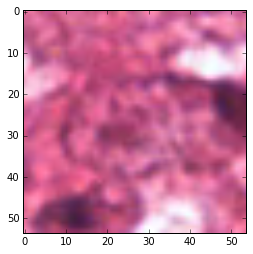

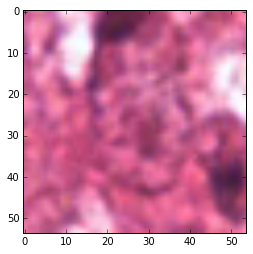

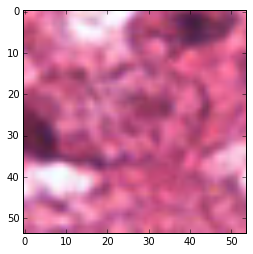

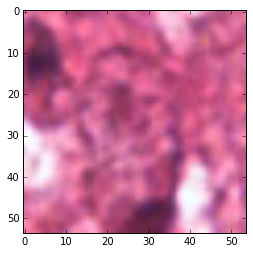

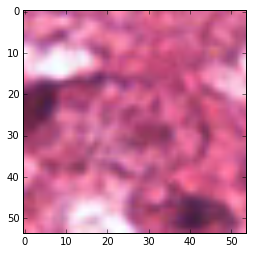

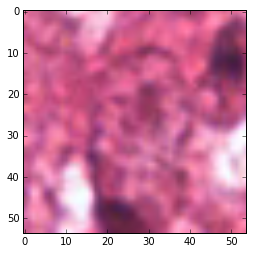

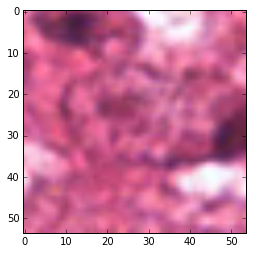

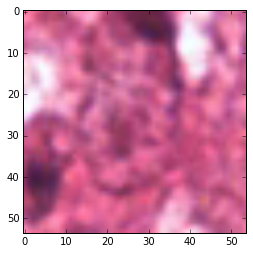

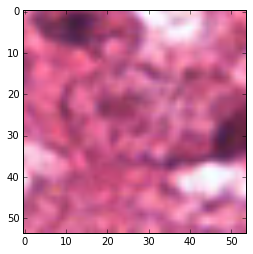

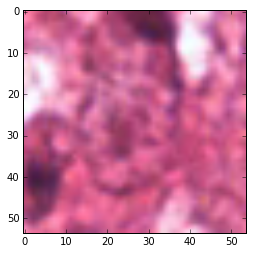

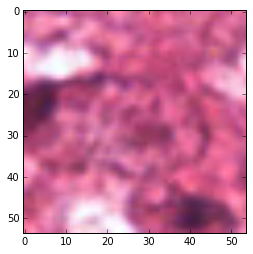

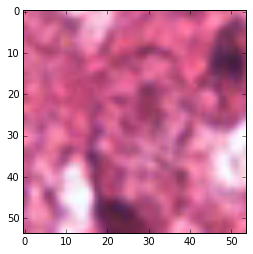

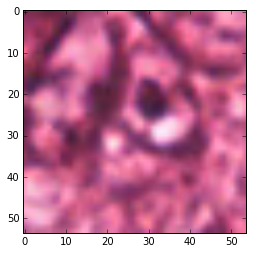

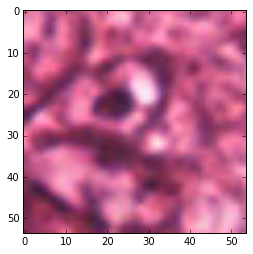

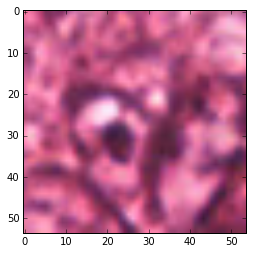

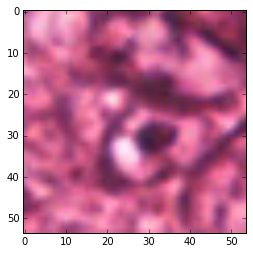

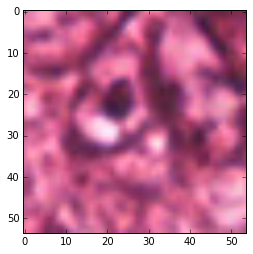

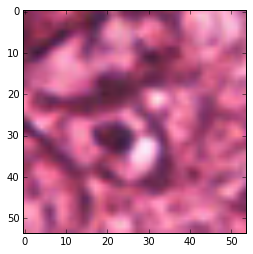

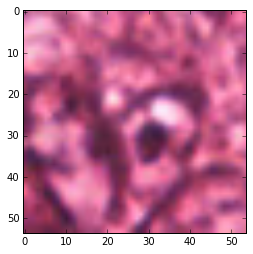

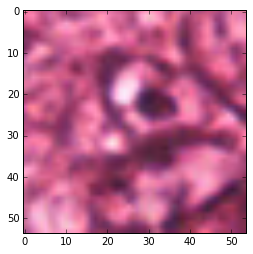

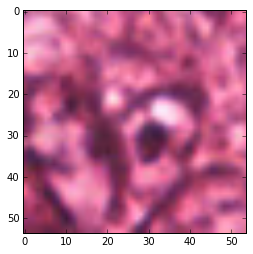

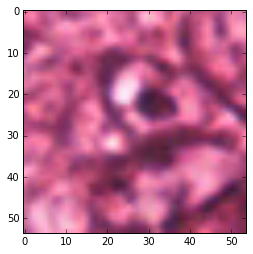

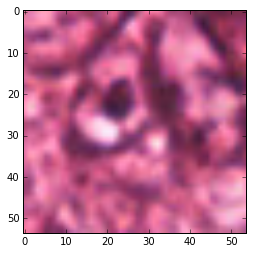

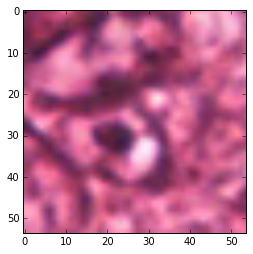

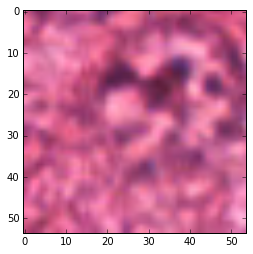

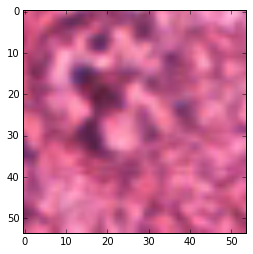

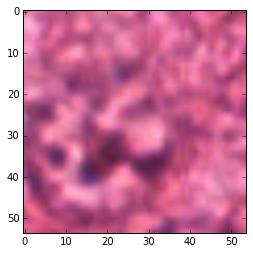

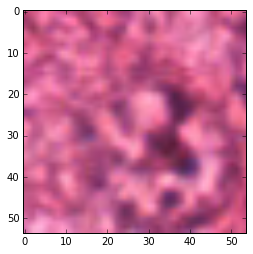

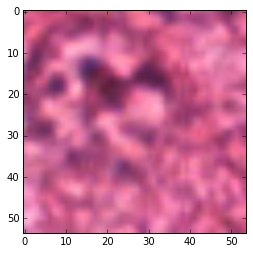

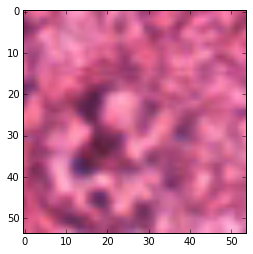

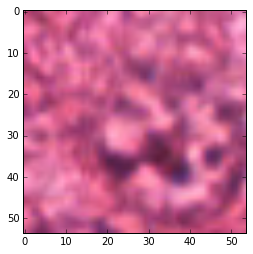

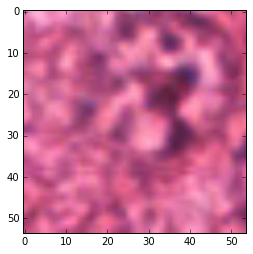

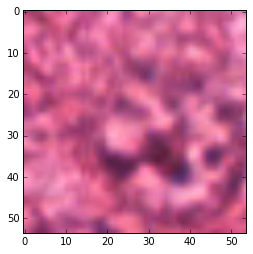

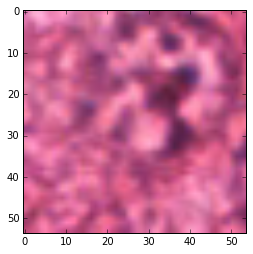

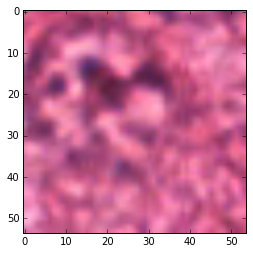

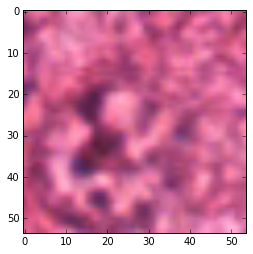

In [13]:
from skimage.transform import rotate

def variations(img_array):
    arr = []
    for img in img_array:
        arr.append(img)
        arr.append(rotate(img, 90))
        arr.append(rotate(img, 180))
        arr.append(rotate(img, 270))
        arr.append(np.fliplr(img))
        arr.append(rotate(np.fliplr(img), 90))
        arr.append(rotate(np.fliplr(img), 180))
        arr.append(rotate(np.fliplr(img), 270))
        arr.append(np.flipud(img))
        arr.append(rotate(np.flipud(img), 90))
        arr.append(rotate(np.flipud(img), 180))
        arr.append(rotate(np.flipud(img), 270))
        
    return np.array(arr)

for img in variations(trainImg[0:3]):
    plt.imshow(img)
    plt.show()